In [30]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        y = self.weight[:, None, None] * x
        # y = torch.mul(self.weight[:, None, None], x)
        x = y + self.bias[:, None, None]
        return x


In [87]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import numpy as np
import torch
from torch import nn

from typing import Any, Optional, Tuple, Type
import matplotlib.pyplot as plt

class  PromptEncoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        image_embedding_size: Tuple[int, int],
        input_image_size: Tuple[int, int],
        mask_in_chans: int,
        activation: Type[nn.Module] = nn.GELU,
    ) -> None:
        """
        Encodes prompts for input to SAM's mask decoder.

        Arguments:
          embed_dim (int): The prompts' embedding dimension
          image_embedding_size (tuple(int, int)): The spatial size of the
            image embedding, as (H, W).
          input_image_size (int): The padded size of the image as input
            to the image encoder, as (H, W).
          mask_in_chans (int): The number of hidden channels used for
            encoding input masks.
          activation (nn.Module): The activation to use when encoding
            input masks.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.input_image_size = input_image_size
        self.image_embedding_size = image_embedding_size
        self.pe_layer = PositionEmbeddingRandom(embed_dim // 2)

        self.num_point_embeddings: int = 4  # pos/neg point + 2 box corners
        point_embeddings = [nn.Embedding(1, embed_dim) for i in range(self.num_point_embeddings)]
        self.point_embeddings = nn.ModuleList(point_embeddings)
        self.not_a_point_embed = nn.Embedding(1, embed_dim)

        self.mask_input_size = (4 * image_embedding_size[0], 4 * image_embedding_size[1])
        self.mask_downscaling = nn.Sequential(
            nn.Conv2d(1, mask_in_chans // 4, kernel_size=2, stride=2),
            LayerNorm2d(mask_in_chans // 4),
            activation(),
            nn.Conv2d(mask_in_chans // 4, mask_in_chans, kernel_size=2, stride=2),
            LayerNorm2d(mask_in_chans),
            activation(),
            nn.Conv2d(mask_in_chans, embed_dim, kernel_size=1),
        )
        self.no_mask_embed = nn.Embedding(1, embed_dim)

    def get_dense_pe(self) -> torch.Tensor:
        """
        Returns the positional encoding used to encode point prompts,
        applied to a dense set of points the shape of the image encoding.

        Returns:
          torch.Tensor: Positional encoding with shape
            1x(embed_dim)x(embedding_h)x(embedding_w)
        """
        return self.pe_layer(self.image_embedding_size).unsqueeze(0)

    def _embed_points(
        self,
        points: torch.Tensor,
        labels: torch.Tensor,
        pad: bool,
    ) -> torch.Tensor:
        """Embeds point prompts."""
        points = points + 0.5  # Shift to center of pixel

        if pad:
            padding_point = torch.zeros((points.shape[0], 1, 2), device=points.device)
            padding_label = -torch.ones((labels.shape[0], 1), device=labels.device)
            points = torch.cat([points, padding_point], dim=1)  #B,N+1,2
            labels = torch.cat([labels, padding_label], dim=1)


        point_embedding = self.pe_layer.forward_with_coords(points, self.input_image_size)  #B,N+1,256
        point_embedding[labels == -1] = 0.0

        self.not_a_point_embed.weight = torch.nn.Parameter(self.not_a_point_embed.weight.to(point_embedding.dtype), requires_grad=True)  # todo
        self.point_embeddings[0].weight = torch.nn.Parameter(self.point_embeddings[0].weight.to(point_embedding.dtype), requires_grad=True) #todo
        self.point_embeddings[1].weight = torch.nn.Parameter(self.point_embeddings[1].weight.to(point_embedding.dtype), requires_grad=True) #todo

        point_embedding[labels == -1] += self.not_a_point_embed.weight 
        point_embedding[labels == 0] += self.point_embeddings[0].weight
        point_embedding[labels == 1] += self.point_embeddings[1].weight
        return point_embedding

    def _embed_boxes(self, boxes: torch.Tensor) -> torch.Tensor:
        """Embeds box prompts."""

        boxes = boxes + 0.5  # Shift to center of pixel
        coords = boxes.reshape(-1, 2, 2)
        corner_embedding = self.pe_layer.forward_with_coords(coords, self.input_image_size)
        corner_embedding[:, 0, :] += self.point_embeddings[2].weight
        corner_embedding[:, 1, :] += self.point_embeddings[3].weight
        return corner_embedding

    def _embed_masks(self, masks: torch.Tensor) -> torch.Tensor:
        """Embeds mask inputs."""
        mask_embedding = self.mask_downscaling(masks)
        return mask_embedding

    def _get_batch_size(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
    ) -> int:
        """
        Gets the batch size of the output given the batch size of the input prompts.
        """
        if points is not None:
            return points[0].shape[0]
        elif boxes is not None:
            return boxes.shape[0]
        elif masks is not None:
            return masks.shape[0]
        else:
            return 1

    def _get_device(self) -> torch.device:
        return self.point_embeddings[0].weight.device

    def forward(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Embeds different types of prompts, returning both sparse and dense
        embeddings.

        Arguments:
          points (tuple(torch.Tensor, torch.Tensor) or none): point coordinates
            and labels to embed.
          boxes (torch.Tensor or none): boxes to embed
          masks (torch.Tensor or none): masks to embed

        Returns:
          torch.Tensor: sparse embeddings for the points and boxes, with shape
            BxNx(embed_dim), where N is determined by the number of input points
            and boxes.
          torch.Tensor: dense embeddings for the masks, in the shape
            Bx(embed_dim)x(embed_H)x(embed_W)
        """
        bs = self._get_batch_size(points, boxes, masks)
        sparse_embeddings = torch.empty((bs, 0, self.embed_dim), device=self._get_device()) #B,0,256  空[]

        if points is not None:
            coords, labels = points     #coords:B,N,2  labels:B,N
            point_embeddings = self._embed_points(coords, labels, pad=(boxes is None))
            sparse_embeddings = torch.cat([sparse_embeddings, point_embeddings], dim=1)

        if boxes is not None:
            box_embeddings = self._embed_boxes(boxes)
            sparse_embeddings = torch.cat([sparse_embeddings, box_embeddings], dim=1)

        if masks is not None:
            dense_embeddings = self._embed_masks(masks)
        else:
            dense_embeddings = self.no_mask_embed.weight.reshape(1, -1, 1, 1).expand(
                bs, -1, self.image_embedding_size[0], self.image_embedding_size[1]
            )

        return sparse_embeddings, dense_embeddings


class PositionEmbeddingRandom(nn.Module):
    """
    Positional encoding using random spatial frequencies.
    """

    def __init__(self, num_pos_feats: int = 64, scale: Optional[float] = None) -> None:
        super().__init__()
        if scale is None or scale <= 0.0:
            scale = 1.0
        self.register_buffer(
            "positional_encoding_gaussian_matrix",
            scale * torch.randn((2, num_pos_feats)),
        )1],[

    def _pe_encoding(self, coords: torch.Tensor) -> torch.Tensor:
        """Positionally encode points that are normalized to [0,1]."""
        # assuming coords are in [0, 1]^2 square and have d_1 x ... x d_n x 2 shape
        coords = 2 * coords - 1
        # coords = coords @ self.positional_encoding_gaussian_matrix
        coords = coords @ torch.ones((2, 128)).to(torch.float32) # todo
        coords = 2 * np.pi * coords
        np.save('/home/mkhanmhmdi/Desktop/coord.npy',coords.detach().numpy())
        # outputs d_1 x ... x d_n x C shape
        np.save('/home/mkhanmhmdi/Desktop/sin-cos.npy',torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1).detach().numpy())

        return torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1)

    def forward(self, size: Tuple[int, int]) -> torch.Tensor:
        """Generate positional encoding for a grid of the specified size."""
        h, w = size

        device: Any = self.positional_encoding_gaussian_matrix.device
        grid = torch.ones((h, w), device=device, dtype=torch.float32)
        y_embed = grid.cumsum(dim=0) - 0.5
        x_embed = grid.cumsum(dim=1) - 0.5
        y_embed = y_embed / h
        x_embed = x_embed / w

        pe = self._pe_encoding(torch.stack([x_embed, y_embed], dim=-1))
        return pe.permute(2, 0, 1)  # C x H x W

    def forward_with_coords(
        self, coords_input: torch.Tensor, image_size: Tuple[int, int]
    ) -> torch.Tensor:
        """Positionally encode points that are not normalized to [0,1]."""
        coords = coords_input.clone()
        coords[:, :, 0] = coords[:, :, 0] / image_size[1]
        coords[:, :, 1] = coords[:, :, 1] / image_size[0]

        return self._pe_encoding(coords.to(torch.float))  # B x N x C


In [88]:
points = (torch.tensor([[[1,1]],

         [[10,10]],

         [[20,20]],

         [[40,40]],

         [[ 60,60]],

         [[80,80]],

         [[100,100]],

         [[120,120]],

         [[140,140]],

         [[160,160]],
         [[170,170]],
         [[180,180]],
         [[190,190]],
         [[200,200]],
         [[210,210]],
         [[220,220]]]),
 torch.tensor([[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
              [1],[1],[1],[1],[1],[1]]))

pad = True
# import csv
# with open('/home/mkhanmhmdi/Desktop/batch_input_sam.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerows(batched_input.items())
    

In [89]:
prompt_embed_dim = 256
image_size = 256
vit_patch_size = 16
image_embedding_size = image_size // vit_patch_size

prompt_encoder=PromptEncoder(
    embed_dim=prompt_embed_dim,
    image_embedding_size=(image_embedding_size, image_embedding_size),
    input_image_size=(image_size, image_size),
    mask_in_chans=16,
)

In [90]:
import csv

batched_input = {}

with open('/home/mkhanmhmdi/Desktop/batch_input_sam.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        my_dict[row[0]] = row[1]


NameError: name 'my_dict' is not defined

In [91]:
sparse_embeddings, dense_embeddings = prompt_encoder(
    points=points,
    boxes=batched_input.get("boxes", None),
    masks=batched_input.get("mask_inputs", None),
)

In [34]:
sparse_embeddings.shape

torch.Size([10, 2, 256])

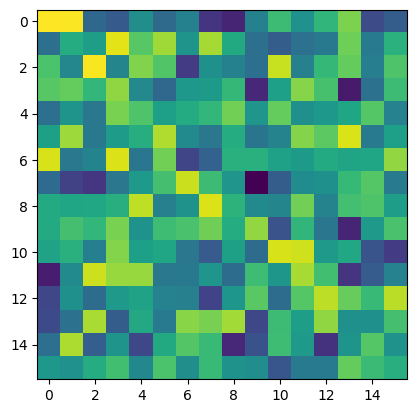

In [36]:
plt.imshow(sparse_embeddings[1,1].reshape(16,16).detach())

In [37]:
import numpy as np

In [39]:
pe = np.load('/home/mkhanmhmdi/Desktop/positional_encoding_gaussian_matrix.npy')

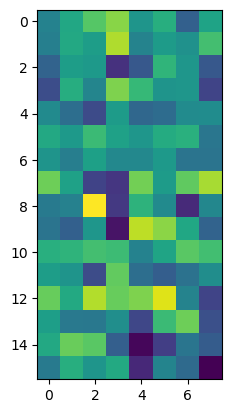

In [49]:
plt.imshow(pe[0].reshape(16,8))

In [61]:
a = np.array([[[[0.3926, 0.3926]]]])@pe

(2, 128)

In [75]:
a[0,0]

array([[ 0.0943191 , -0.51089255,  0.51159517,  0.98759679,  0.26916823,
         0.36821341, -0.41499423,  0.19343309, -0.28094593,  0.00947486,
        -0.24857069,  1.25363571, -0.18828235,  0.64487781,  0.02988816,
        -0.23869827, -0.41471396,  0.25730528, -0.32432363, -0.11516958,
        -0.50021112,  0.15168961,  0.24297025,  0.49227072, -1.12370277,
         0.25483151, -0.34114097,  0.73194384,  0.35963708, -0.03283023,
         0.1140851 , -0.33538904, -0.24060301, -0.1194947 , -0.34787503,
        -0.07717988, -0.70127419,  0.04434788, -0.24178234, -0.55628637,
        -0.49513005,  0.26439593, -0.10564384, -0.29588579,  0.09605848,
         0.04504763,  0.2894391 , -0.4499202 , -0.48544668,  0.26894019,
         0.27994419,  0.14663639, -0.16694041,  0.44431577, -0.52856035,
        -1.02097118,  0.28768999, -0.38655175, -0.62891943, -0.61340903,
         0.72176321, -0.36525819,  0.32348244,  0.99840854, -0.57832233,
         0.43709753,  1.13979685, -0.19453399, -0.1

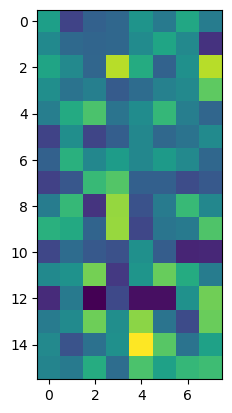

In [65]:
plt.imshow(a[0,0].reshape(16,8)-pe[0].reshape(16,8))

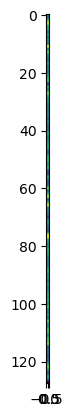

In [69]:
plt.imshow(a[0,0].reshape(128,1))

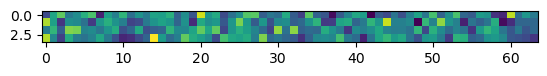

In [85]:
plt.imshow(sparse_embeddings.detach()[0,0].reshape(4,64))

In [92]:
coords = np.load('/home/mkhanmhmdi/Desktop/coord.npy')

In [93]:
coords.shape

(16, 2, 128)

In [94]:
coords = coords.squeeze()

In [95]:
coords.shape

(16, 2, 128)

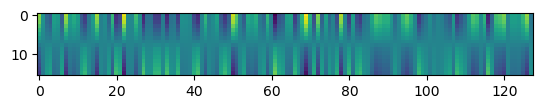

In [78]:
plt.imshow(coords[:,0,:])

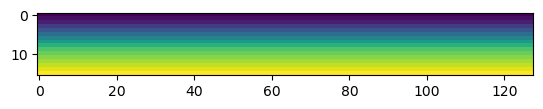

In [96]:
plt.imshow(coords[:,0,:])

In [97]:
coords = np.load('/home/mkhanmhmdi/Desktop/sin-cos.npy')

In [98]:
coords.shape

(16, 2, 256)

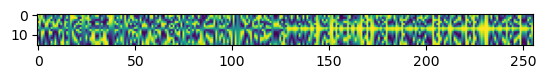

In [81]:
plt.imshow(coords[:,0,:])

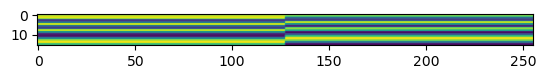

In [99]:
plt.imshow(coords[:,0,:])